In [ ]:
import argparse
import torch
import torch.backends.cudnn as cudnn
from torchvision import models
import sys
import os
# sys.path.append(os.path.abspath('../simCLR'))

from data_aug.contrastive_learning_dataset import ContrastiveLearningDataset
from models.resnet_simclr import ResNetSimCLR
from simclr import SimCLR

import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

/home/abhinav-kompella/miniforge3/envs/dl_3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = ResNetSimCLR(base_model='resnet18', out_dim=128)
device = "cpu"
checkpoint = torch.load('/home/abhinav-kompella/Documents/CV/cvProject/src/SimCLR/checkpoint_1000.pth(1).tar', map_location=device)
model.load_state_dict(checkpoint['state_dict'])

/home/abhinav-kompella/miniforge3/envs/dl_3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/abhinav-kompella/miniforge3/envs/dl_3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [4]:
# model = torch.hub.load('facebookresearch/swav:main', 'resnet50')

In [ ]:
import numpy as np

model.eval()

feature_maps = []
gradients = []

def forward_hook(module, input, output):
    feature_maps.append(output)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

target_layer = model.backbone.layer1
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

Files already downloaded and verified
Class index: 3 -> Label1: 3, Label2: 3
img1 shape: (32, 32), img2 shape: (32, 32)


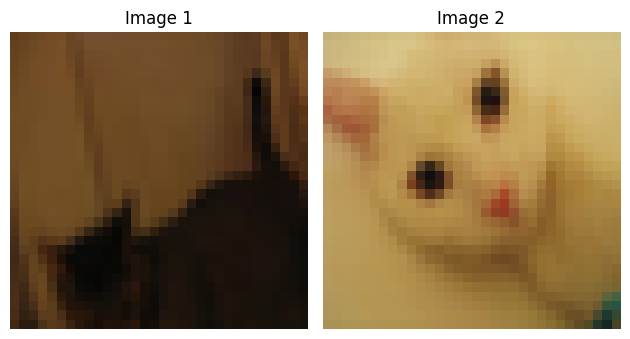

In [6]:
dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=None
)

target_class = 3

# Get all indices of images belonging to the target class
indices = [i for i, (_, label) in enumerate(dataset) if label == target_class]

# Randomly select two distinct indices from that class
idx1, idx2 = random.sample(indices, 2)

# Extract the images
img1, label1 = dataset[idx1]
img2, label2 = dataset[idx2]

print(f"Class index: {target_class} -> Label1: {label1}, Label2: {label2}")
print(f"img1 shape: {img1.size}, img2 shape: {img2.size}")

# Show both images
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title("Image 2")
plt.axis('off')

plt.tight_layout()
plt.show()

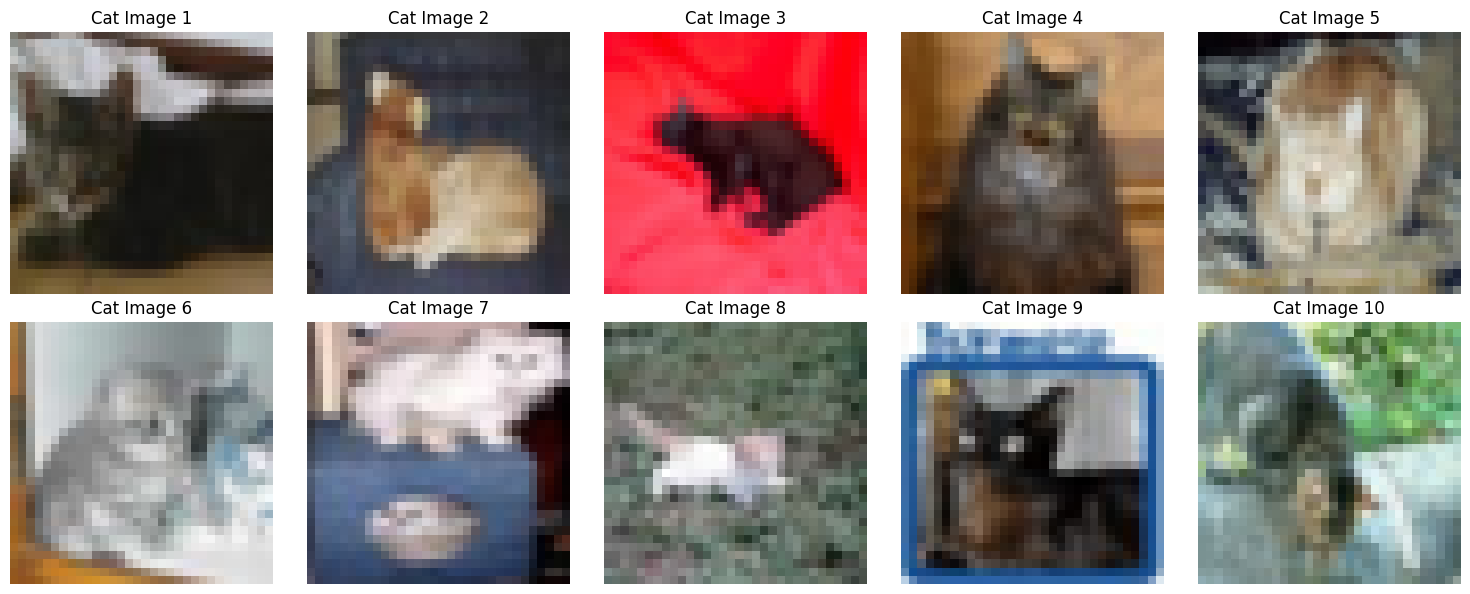

In [ ]:
cat_class = 3
cat_images = []

for i in range(len(dataset)):
    img, label = dataset[i]
    if label == cat_class:
        cat_images.append(img)
    if len(cat_images) == 10:  
        break

# Plot the images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, img in enumerate(cat_images):
    axes[i].imshow(img)  # Convert to HWC format for plotting
    axes[i].axis('off')
    axes[i].set_title(f"Cat Image {i+1}")

plt.tight_layout()
plt.show()

In [ ]:
# x1 = img1.unsqueeze(0).to(device)  # Add batch dimension
# x2 = img2.unsqueeze(0).to(device)
device = "cpu"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # CIFAR-10 mean
                         (0.2023, 0.1994, 0.2010))  # CIFAR-10 std
])

# Apply the transform to both images
x1 = transform(cat_images[0]).unsqueeze(0).to(device)  # [1, 3, 32, 32]
x2 = transform(cat_images[3]).unsqueeze(0).to(device)

feature_maps.clear()
gradients.clear()

embedding1 = model(x1)
embedding2 = model(x2)

# Cosine similarity between embeddings
similarity = F.cosine_similarity(embedding1, embedding2)

# Backward pass to compute gradients
model.zero_grad()
similarity.backward() 

# Grad-CAM
# Feature maps and gradients have been collected
fm   = feature_maps[0]  # [1,256,2,2]  if layer3
grad = gradients[0]     # [1,256,2,2]

weights = grad.mean(dim=[2,3], keepdim=True)      # [1,256,1,1]
cam     = (weights * fm).sum(dim=1, keepdim=True) 

print(cam.shape)
cam     = F.relu(cam)
cam     = F.interpolate(cam, size=(32,32),
                        mode='bilinear', align_corners=False)

torch.Size([1, 1, 8, 8])


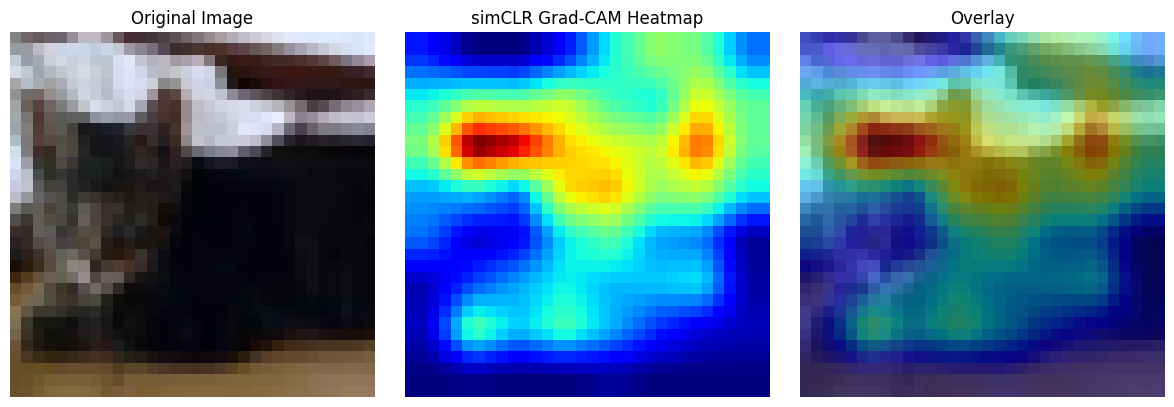

In [ ]:
cam_np  = cam.squeeze().cpu().detach().numpy()

cam_np  = (cam_np - cam_np.min()) / (cam_np.max() - cam_np.min())  # Normalize
# 7. Plot
input_img = x1.squeeze().permute(1, 2, 0).cpu().detach().numpy()
input_img = (input_img - input_img.min()) / (input_img.max() - input_img.min())  # normalize to [0,1] 

heatmap = cam.squeeze().detach().cpu().numpy()
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # normalize CAM

plt.figure(figsize=(12, 4))

# 1. Original image
plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title("Original Image")
plt.axis('off')

# 2. CAM heatmap alone
plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title("simCLR Grad-CAM Heatmap")
plt.axis('off')

# 3. Overlay
plt.subplot(1, 3, 3)
plt.imshow(input_img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title("Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from itertools import combinations

img_tensor_list = [transform(cat_images[i]).unsqueeze(0).to(device) for i in range(len(cat_images))]

with torch.no_grad():
    embeddings = [model(x).squeeze(0) for x in img_tensor_list]

fixed_idx = 0  # First image as the reference
fixed_embedding = embeddings[fixed_idx] 

scores = []
pairs = []

for j in range(0, len(embeddings)):  
    if j == fixed_idx:
        continue
    sim = F.cosine_similarity(fixed_embedding.unsqueeze(0), embeddings[j].unsqueeze(0)).item()
    scores.append(sim)
    pairs.append((fixed_idx, j))

# max and min similarity pairs
max_idx = np.argmax(scores)
min_idx = np.argmin(scores)

max_pair = pairs[max_idx]
min_pair = pairs[min_idx]

print(f"Max similarity ({scores[max_idx]:.4f}) between indices: {max_pair}")
print(f"Min similarity ({scores[min_idx]:.4f}) between indices: {min_pair}")

Max similarity (0.8065) between indices: (0, 8)
Min similarity (-0.0116) between indices: (0, 5)


In [11]:
def run_gradcam_on_pair(x1, x2, model, feature_maps, gradients, device):
    # Clear previous hooks' outputs
    feature_maps.clear()
    gradients.clear()

    # Ensure inputs require gradients
    x1 = x1.to(device)
    x2 = x2.to(device)
    x1.requires_grad_()
    x2.requires_grad_()

    # Forward pass
    model.eval()
    embedding1 = model(x1)
    embedding2 = model(x2)

    # Similarity and backward
    similarity = F.cosine_similarity(embedding1, embedding2)
    model.zero_grad()
    similarity.backward()

    # Grad-CAM computation
    fm = feature_maps[0]   # Shape: [1, C, H, W]
    grad = gradients[0]    # Shape: [1, C, H, W]

    weights = grad.mean(dim=[2, 3], keepdim=True)           # [1, C, 1, 1]
    cam = (weights * fm).sum(dim=1, keepdim=True)           # [1, 1, H, W]
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=(32, 32), mode='bilinear', align_corners=False)

    # Normalize CAM
    cam_np = cam.squeeze().cpu().detach().numpy()
    cam_np = (cam_np - cam_np.min()) / (cam_np.max() - cam_np.min() + 1e-8)

    return cam_np


x1_max, x2_max = img_tensor_list[max_pair[0]], img_tensor_list[max_pair[1]]
x1_min, x2_min = img_tensor_list[min_pair[0]], img_tensor_list[min_pair[1]]

cam_max1 = run_gradcam_on_pair(x1_max, x2_max, model, feature_maps, gradients, device)
cam_min1 = run_gradcam_on_pair(x1_min, x2_min, model, feature_maps, gradients, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


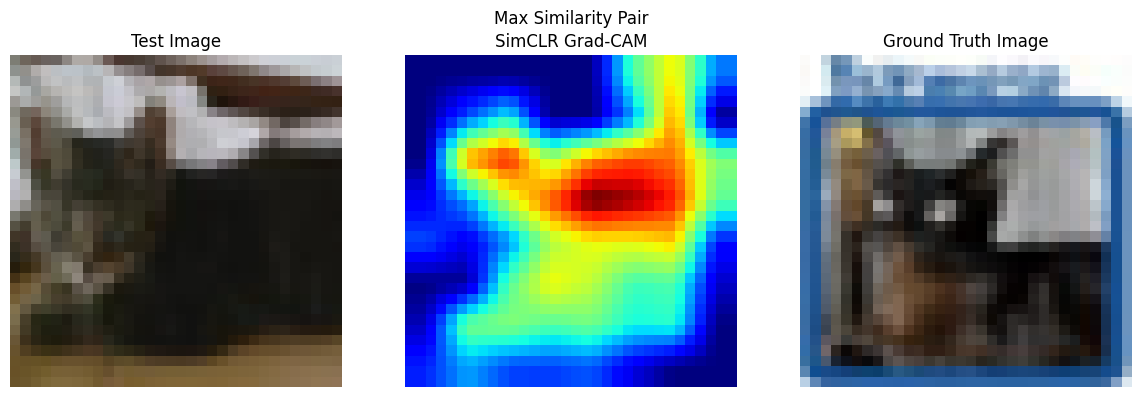

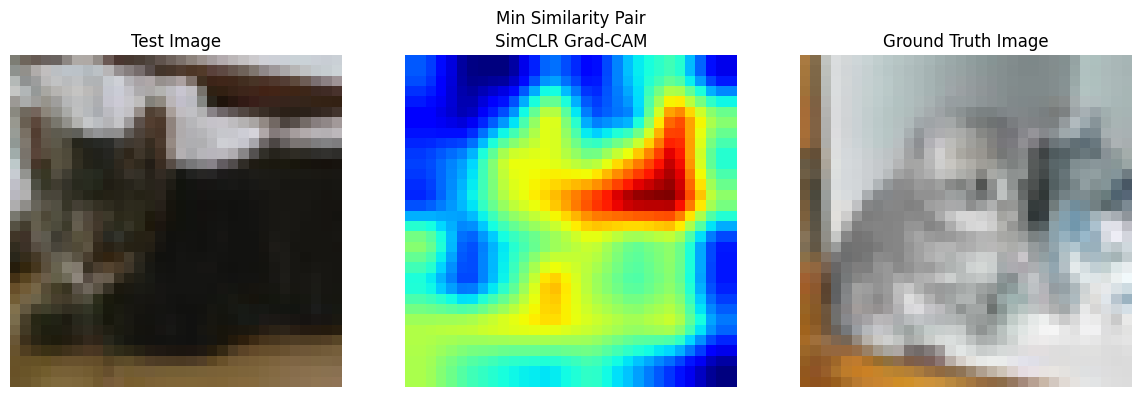

In [ ]:
def denormalize(tensor, mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)):
    mean = torch.tensor(mean).reshape(3, 1, 1)
    std = torch.tensor(std).reshape(3, 1, 1)
    return tensor * std + mean

def plot_gradcam_results(img1, img2, cam1, cam2, title):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))  

    # Image 1
    img1 = denormalize(img1).permute(1, 2, 0).cpu().detach().numpy()
    axs[0].imshow(img1)
    axs[0].set_title("Test Image")

    # CAM 1
    axs[1].imshow(cam1, cmap='jet')
    axs[1].set_title("SimCLR Grad-CAM")

    # Image 2
    img2 = denormalize(img2).permute(1, 2, 0).cpu().detach().numpy()
    axs[2].imshow(img2)
    axs[2].set_title("Ground Truth Image")

    for ax in axs:
        ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_gradcam_results(x1_max.squeeze(0), x2_max.squeeze(0), cam_max1, cam_max1, "Max Similarity Pair")
plot_gradcam_results(x1_min.squeeze(0), x2_min.squeeze(0), cam_min1, cam_min1, "Min Similarity Pair")


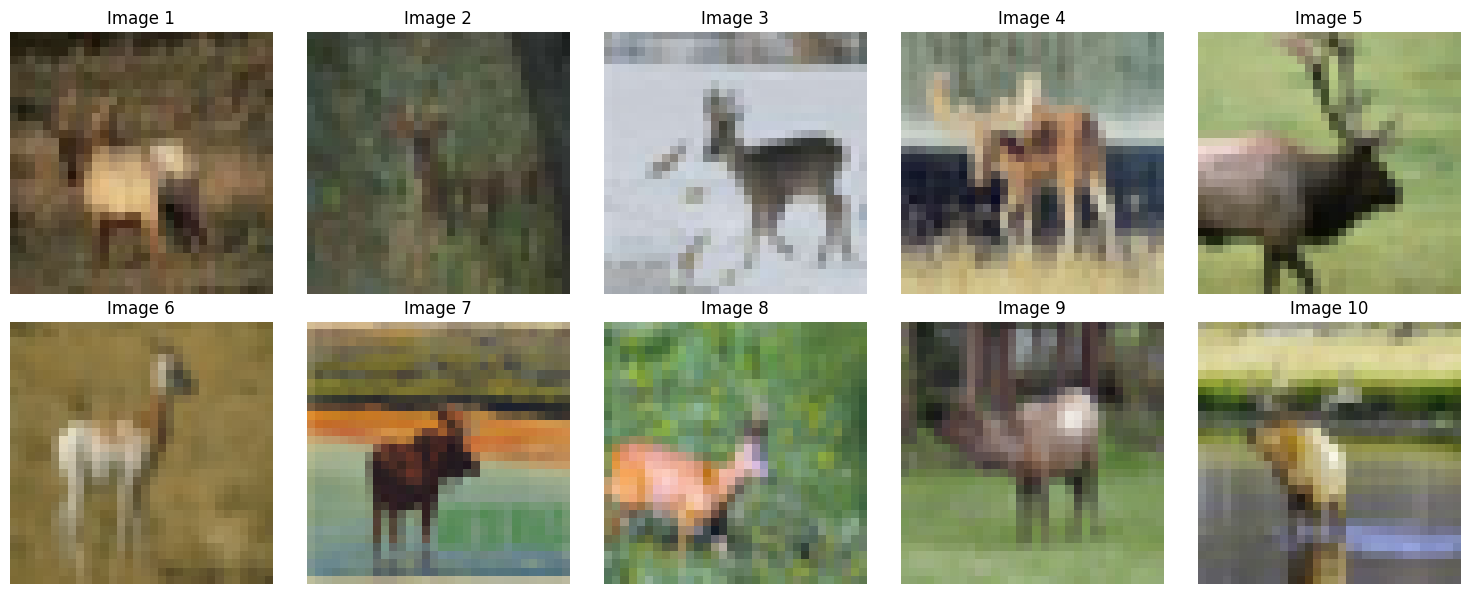

In [ ]:
some_class = 4
some_images = []

for i in range(len(dataset)):
    img, label = dataset[i]
    if label == some_class:
        some_images.append(img)
    if len(some_images) == 10: 
        break

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, img in enumerate(some_images):
    axes[i].imshow(img)  # Convert to HWC format for plotting
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

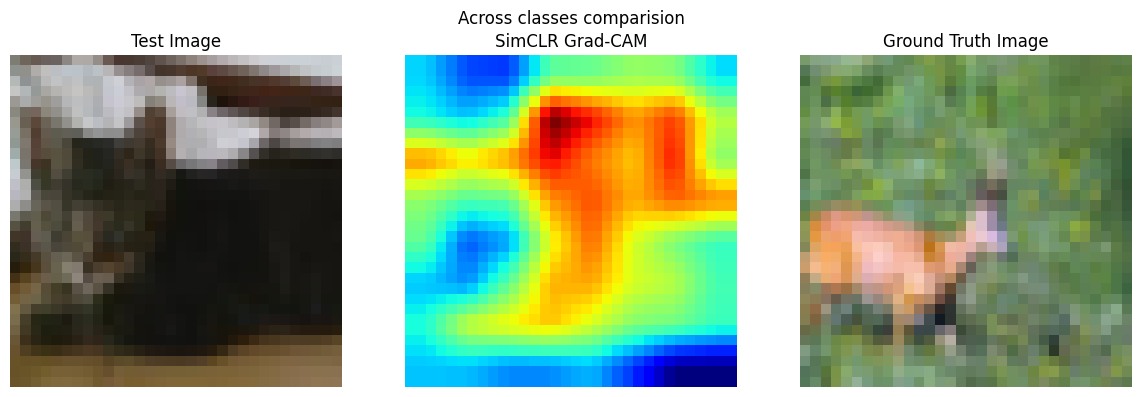

In [18]:
x_deer = transform(some_images[7]).unsqueeze(0).to(device)
cam_diff = run_gradcam_on_pair(x1_max, x_deer, model, feature_maps, gradients, device)

plot_gradcam_results(x1_max.squeeze(0), x_deer.squeeze(0), cam_diff, cam_diff, "Across classes comparision")
